# Modelling of air-quality in Belgium for forecasting purposes using Deep Neural Networks

#### Konstantinos Theodorakos  
*Katholieke Universiteit Leuven*  
*Student of the Master Artificial Intelligence: Engineering and Computer Science*  
*Faculty of Engineering Science*  
*Departments of Computer Science & Electrical Engineering, ESAT-STADIUS*  
*Kasteelpark Arenberg 10*  
*Leuven (Heverlee), Belgium*  
*Email: Konstantinos.Theodorakos@student.kuleuven.be*

# BACKGROUND

## Ozone

Ozone (see: https://en.wikipedia.org/wiki/Ozone ), is an inorganic molecule, a less stable allotrope of oxygen. It has industrial and consumer applications as an oxidant, but it causes damage to mucous and respiratory tissues of humans and animals.

![Alt Text](pics/1200px-Atmospheric_ozone.svg.png)

*Figure: Ozone distribution on the Earth's atmosphere (source: https://en.wikipedia.org/wiki/File:Atmospheric_ozone.svg ).*

# 1. METHODS
## Data handling & time-series split

Sensor data points that were flagged as invalid were omitted entirely. For the 1-station ozone prediction experiments, linear interpolation is filling the missing values. For all the other 4+ station experiments, missing data points are covered by: (1) data from the geographically closest stations and (2) linear interpolation (in case there are still missing values).

For the model selection, a unique form of k-fold cross-validation was used: **time-series split** [3] see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html ). In each split, shuffling is omitted, in order to retain the sequence of the full time-series. In addition, the model is trained with data of increasing total time-step count. The mean validation Mean Squared Error (MSE) determines whether a model is optimal and generalizes well. The "test" data is held-out from the start, never used in model selection. For all the experiments, time-series split had had 10-folds.
![title](pics/timeSeriesValidateSplit.png)


## Neuroevolution with "Island Transpeciation"

Neuroevolution [21] is an algorithmic method that utilizes *Evolutionary Algorithms* *(EA)* [18] to generate Artificial Neural Network (ANN) [22] parameters, topologies [5, 6, 10, 11, 12] and rules (see: https://en.wikipedia.org/wiki/Neuroevolution ). In order to find an optimal deep learning model for the time-series forecasting [8, 9] task, architecture search is performed in conjunction with hyper-parameter tuning [23, 34]. Speciation is the evolutionary process by which populations evolve to become distinct species (see: https://en.wikipedia.org/wiki/Speciation ). With *island speciation*, neuroevolution can be parallelized: Each island [24, 33] can be a distinct thread, process or even a different computing node. Even though the evolution progresses distinctly in each island, populations of meta-learning agents migrate periodically between islands.

Every island can have the same global optimization technique (with similar or different settings versus the other islands), a **species**. A global optimizer like Differential Evolution (DE) [17] (see: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.differential_evolution.html ), maintains a number of different agents internally, that are used in a parameter search. An agent has a different internal representation (*genotype*) depending on the meta-heuristic algorithm. The actual bounded parameter set, the *phenotype*, is a candidate Deep Neural Network (DNN) [6] model architecture that we try to optimize. Within the DE implementation, there exist 2-way operations that can perform genotype-to-phenotype representation conversions and vice-versa.

Three types of global optimization EA islands were used:
- **Random (Rand)** [19] island. Creates a random model, by sampling the bounded hyper-parameter values from a uniform pseudo-random number generator. In this case genotype = phenotype and the island population is 1.

- **Differential Evolution** island. Genotype: energy (real values in [0,1]). Phenotype: the genotype values, scaled from [0, 1] into the bounds of each parameter.
![Alt Text](pics/Ackley.gif)
*Figure: Example of Differential Evolution optimizing the 2D Ackley function using a population of size 20 (source: https://en.wikipedia.org/wiki/Differential_evolution#/media/File:Ackley.gif ).*


- **Particle Swarm Optimization (PSO)** [16] island (see: https://pythonhosted.org/pyswarm/ ). Genotype: position (multi-dimensional representation of the parameters as real values) and velocity (rate of change of the positions).
![Alt Text](pics/ParticleSwarmArrowsAnimation.gif)
*Figure: A particle swarm searching for the global minimum of a function (source: https://en.wikipedia.org/wiki/Particle_swarm_optimization#/media/File:ParticleSwarmArrowsAnimation.gif ).*

In some cases, it is possible to convert an agent from one global optimization method to another. For example, to convert a DE to a PSO agent: the agent of the DE "species" is converted from the DE genotype to the common phenotype (by unscaling real values) and then is converted to the PSO genotype (real values = position & velocity). We define this conversion process as **island transpeciation** (see: http://www.websters1913.com/words/Transpeciate ). Loosely termed, transpeciation acts as a (lossy in some cases) *transformation function* between the agent genotypes of different global optimization functions. Transpeciation in conjunction with the island model, allow combination (via *migration*) and diversification (via unique evolution per island) of different model architecture search methods.

Worth noting is that in order to keep the populations stable on all islands, the migrating agents replace a random agent at the receiving island. In practice, it was a matter of replacing an agent entry on the internal data structures of the EA algorithms. For the local experiments, the island population was fixed to 5 agents.

In the future, there will be attempts to integrate additional meta-learning islands such as:
- Genetic Algorithm (GA) [13, 14, 15].
- (Multi-agent) Reinforcement Learning (RL) [4].
- Basin Hopping (BH) [20].
- Estimation of distribution algorithms (EDA) [26], or probabilistic model-building genetic algorithms (PMBGAs) [25].
- Tree-structured Parzen Estimator (TPE) [34].

![title](pics/agentIslandTranspeciation.png)

## Architecture search genes

The genes are expressed as bounded real or integer values. They can represent:
- Cells/layers of a sequential DNN.
- Various model hyper-parameters/rates.
- Training optimizers.

### Cell Sequence search

The candidate models contain 4 base layers:
- 3x Long-Short Term Memory (**LSTM**) [27].
- 1x **Fully Connected** cell at the end.

The **auxiliary/utility cells** are placed between the base layers. Auxiliary cells placements are determined purely by the evolutionary search process:

- Batch Normalization [36].
- Gaussian Noise [37].

![title](pics/cells.png)

### Hyper-Parameter search

The following **bounded parameters** (ranges expressed in the parentheses) are searched:
- Standard Deviation of the Gaussian noise.
- Dropout/Recurrent-dropout [35] rate: Fraction of neurons to randomly ignore while training; reduces overfitting.
- Cell/layer size.
- Max training epochs.
- Batch size per epoch.




![title](pics/hyperParameters.png)

### Optimizer search

**Optimizers** are the algorithms that guide the weight training process of an ANN. The following optimizer options are possible (https://keras.io/optimizers/):

- Adagrad (Adaptive Subgradient) [38].
- Adadelta [39].
- Adam, adamax [40].
- Adam (amsgrad version) [41].
- Nadam (adam with Nesterov momentum) [42].

![title](pics/optimizers.png)

It is a subset of the total optimizers available, the only valid options for Recurrent Neural Networks (RNN).

### Overfitting avoidance

**Early Stopping** and **Learning-Rate reduction on plateau** (see: https://keras.io/callbacks/ ) use the *loss* and *validation_loss* values of Mean Squared Error (MSE) during training, to approach a finely-trained model and to avoid overfitting.

### Parallelism
An asynchronous version of the **Master-Slave pattern** (see: http://charm.cs.uiuc.edu/research/masterSlave ) allowed for CPU and GPU parallelism of different island species. Agent migration is carried out by slaves (islands) sending candidates to the master (main CPU process). The master decides when and to which island to migrate an agent. **Message Passing Interface (MPI)** (see: https://www.mpi-forum.org/docs/ ) handles the communication between the islands and the master (see: https://mpi4py.readthedocs.io/en/stable/tutorial.html#point-to-point-communication ).

The parallel implementation was tested on a local workstation (6 physical CPU cores, 2x Cuda capable GPUs), as well as on the Amazon Elastic Compute Cloud (EC2), on a p3.8xlarge Amazon Machine Image (AMI) (see: https://aws.amazon.com/ec2/instance-types/p3/ ) containing 4x Tesla V100 GPUs. *Note: unfortunately, for now, the models/weights trained on the cloud are incompatible with the local tensorflow installation. After the completion of the "Python for HPC" seminar, the GPU cluster of the VSC super-computer will be utilized (see: https://www.vscentrum.be/ )*.

# 2. MODELS & RESULTS
## Naive method, using the previous step (Naive-1)

The Naive-1 method is the simplest forecasting model, which can serve as a benchmark against the more sophisticated methods.

Background-rural both for Ozone (O3 - Max daily 8-hour mean max8h ozone concentrations) is being read from disk as a CSV file (Older database: https://www.eea.europa.eu/data-and-maps/data/airbase-the-european-air-quality-database-8) for the stations in Belgium: BETN073.

In [12]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot
# Make plots inline
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

station = "BETN073"
modelLabel = "rand"

dataManipulation = {
    "detrend": False,
    "scale": None,
#     "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts

row2000_01_01 = 3653 - 1
row2010_12_31 = 7670
r = r[row2000_01_01:row2010_12_31,:]

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)
print("y_data shape:", y_data.shape)
y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

Loading data...
Using scale: None
r shape: (8035, 59)

Start Array r:
 27.25
Variables: 52
TimeSteps: 4018
x_data shape: (4018, 52)
y_data shape: (4018, 1)


Store data to csv for direct comparisons:

In [13]:
print(r.shape)
print(r[0, 0], r[1, 0], r[-2, 0], r[-1, 0])

(4018, 53)
27.25 38.875 38.5 34.25


In [14]:
import pandas as pd
df1 = pd.DataFrame(r)
df1.to_csv('data_51vars_comparisons.csv')

### Naive-1 prediction & metrics

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return 100.0 * np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # In %
def index_of_agreement(validation, prediction):
    return 1 - (np.sum((validation - prediction) ** 2)) / (np.sum((np.abs(prediction - 
      np.mean(validation)) + np.abs(validation - np.mean(validation))) ** 2))

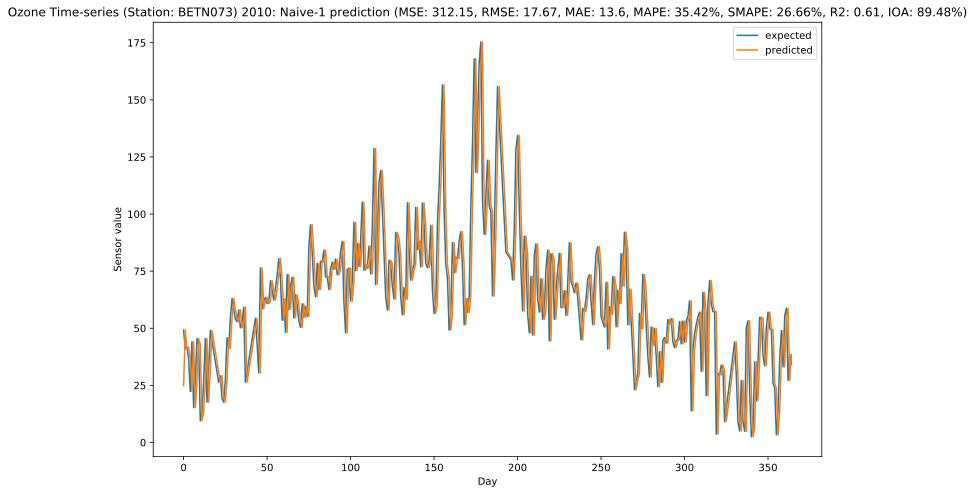

In [16]:
year = 2010
lag = 1
data = r[-365:,0]
ts_lag1 = r[-365:,52]

MSE = mean_squared_error(data, ts_lag1)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(data, ts_lag1)
MAPE = mean_absolute_percentage_error(data, ts_lag1)
SMAPE = smape(data, ts_lag1)
R2_score = r2_score(data, ts_lag1)
IOA = index_of_agreement(data, ts_lag1)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: Naive-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(data)
pyplot.plot(ts_lag1)
ax.legend(['expected', 'predicted'])

Metric Abbreviations:
- MSE: Mean Squared Error
- MAE: Mean Absolute Error
- MAPE: Mean Absolute Percentage Error [32]
- SMAPE: Symmetric Mean Absolute Percentage Error [29, 30]
- IoA: Index of Agreement [31]

## Naive LSTM Multiple-Input Single-Output (MISO) Nonlinear AutoRegressive eXogenous model with lag of 1 day (NARX-1)

The Naive LSTM model, is one of the simplest recurrent models possible: uses a single LSTM layer and 1 fully connected layer at the end. The typical Recurrent Neural Network (RNN) and Gated Recurrent Unit (GRU) layer options on this simple architecture were dropped, due to inferior performance (see: https://keras.io/layers/recurrent/ ), with Mean Absolute Percentage Error (MAPE) ~ 65%, much worse than the Naive-1 baseline.

Loading of the standardized data (1 sensor prediction + 51 weather variables [28]):

In [17]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
#     "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts

row2000_01_01 = 3653 - 1
row2010_12_31 = 7670
r = r[row2000_01_01:row2010_12_31,:]
print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)
print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

Loading data...
Using scale: standardize
r shape: (8035, 59)

Start Array r:
 -1.1751806026215357
Variables: 52
TimeSteps: 4018
x_data shape: (4018, 52)
y_data shape: (4018, 1)


In [27]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from keras.models import model_from_json
import pandas as pd

# json_file = open('runs/naiveLstm/foundModels/bestModelArchitecture.json', 'r')
#json_file = open('runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp/local/foundModels/bestModelArchitecture.json', 'r')
json_file = open('runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp/TX2/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("runs/naiveLstm/foundModels/bestModelWeights.h5")
#loaded_model.load_weights("runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp/local/foundModels/bestModelWeights.h5")
loaded_model.load_weights("runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp/TX2/foundModels/bestModelWeights.h5")

Naive LSTM model:
- 1x Bi-directional Long-Short Term Memory (LSTM) cell of size 64 with 1 dense layer at the end:
![title](runs/naiveLstm/foundModels/deModelIter1.png)

In [19]:
sensor_mean = pd.read_pickle("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_mean.pkl")
sensor_std = pd.read_pickle("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

In [20]:
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

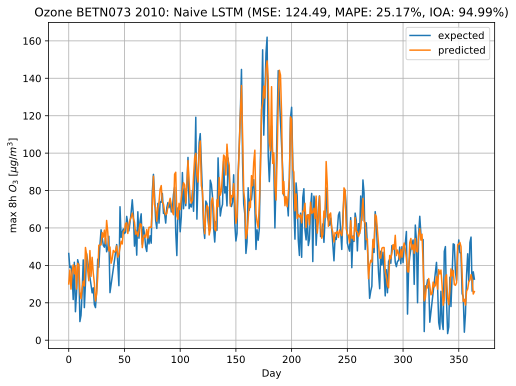

In [28]:
holdout_prediction = loaded_model.predict(x_data_holdout)
figure_size = (8, 6)

prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
# ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
# ax.set_title('Ozone Time-series (Station: {}) {}: Naive LSTM MISO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.set_title('Ozone {} {}: Naive LSTM (MSE: {}, MAPE: {}%, IOA: {}%)'.format(station, year, np.round(MSE,2), np.round(MAPE,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])
ax.grid(True)
# fig.savefig('naiveLstmBETN073.svg', bbox_inches='tight')
fig.savefig('naiveLstmBETN073.svg')

## Deep LSTM MISO NARX-1

The Deep LSTM MISO models use a sequence architecture of:
- 3x Bidirectional LSTM base cells.
- 1-3x Gaussian Noise and/or Batch Normalization auxiliary cells.

Two model versions were used in the experiments:
- Trained with 10 years of data (training: 2000-2009, testing: 2010).
-  Trained with 20 years of data (training: 1990-2009, testing: 2010). The chosen stations (BETN022, BETN066, BETN07e, BETN122) were some of the few that had data since 1990, but they were many weeks or even months of missing data in the first years.

### 10 years training, 1 year testing

Loading of the model (best chosen after 15 island search iterations):

In [ ]:
json_file = open('runs/2gpuPsoDe1stationNarx1_10years/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpuPsoDe1stationNarx1_10years/foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells with 1 gaussian noise cell:
![title](runs/2gpuPsoDe1stationNarx1_10years/foundModels/deModelIter1.png)

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)
figure_size = (8, 6)

prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
# ax.set_title('Ozone Time-series (Station: {}) {}: Deep LSTM MISO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.set_title('Ozone {} {}: Island DNN (MSE: {}, MAPE: {}%, IOA: {}%)'.format(station, year, np.round(MSE,2), np.round(MAPE,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])
#pyplot.savefig("deepLstmMisoNarx1.svg")  # TODO: check printout
ax.grid(True)
# fig.savefig('deepLstmMisoNarx1.svg', bbox_inches='tight')
fig.savefig('deepLstmMisoNarx1.svg')

## Summary (MISO - 1 ozone station)

All the models except the last, use 10 years of data (station BETN0073): 2000-2009 for training and 2010 for testing. The LSTM models use 51 weather variables, gathered from the surface-level ERA-interim ECMWF database (see: https://apps.ecmwf.int/datasets/data/interim-full-daily/levtype=sfc/ ). We can see that the *Naive LSTM NARX-1* model, with a lag of 1 day has slightly lower MSE and better Index of Agreement (IoA) versus the Fixed-Size Least Squares Support Vector Machine (*FS-LSSVM*). The downside was the longer training time (~5 minutes) compared to the kernel-based approach, and the Mean Absolute Percentage Error (MAPE) was ~5.38% higher, signigicantly worse. Training time was even more substantial for the **Deep LSTM NARX-1** (~18 minutes, using the full island speciation process), but we can see that it achieves the best performance for the 10-year dataset: MAPE below 25%, IoA at 95% and MSE significantly  lower than the other methods.

*Note: The data for Value NAR-1, LSSVM NARX and FS-LSSVN models were gathered from the previous thesis on ozone modelling [1, 2], using linear interpolation for the years 2000-2010. Unfortunately, there was no direct mention on the related section about the exogenous variables used and no MAE or SMAPE measurements. For the LSTM methods, all the 51 valid weather time-series were utilized.*

|Metric| Naive-1 | Value NAR-1 | LSSVM NARX | FS-LSSVM NARX | Naive LSTM NARX-1 | Deep LSTM NARX-1
|------|------|------|------|------|------|------|
|   **MSE**  | 312.15 | 281.685| 241.045 | 163.467| 160.34 | **135.48**
|   **MAE**  | 13.60 | -| - | -| 9.78 | **9.33**
|   **MAPE** | 35.42% | 37.8% | 51.2% | 25.8% |31.18% | **23.56%**
|   **SMAPE**  | 26.66% | - | - | - | 20.3% | **19.25%**
|   **IoA**  | 89.48% | 88.6% | 93.2% | 94.6%| 93.4% | **95.12%**

In [ ]:
json_file = open('runs/2gpuPsoDe1stationNarx1_10years/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpuPsoDe1stationNarx1_10years/foundModels/bestModelWeights.h5")

# BETN073 - 2018

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return 100.0 * np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # In %
def index_of_agreement(validation, prediction):
    return 1 - (np.sum((validation - prediction) ** 2)) / (np.sum((np.abs(prediction - 
      np.mean(validation)) + np.abs(validation - np.mean(validation))) ** 2))

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
    # "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 5,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

from tensorflow.keras.models import model_from_json
year = 2018
lag = 1
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))


r = np.genfromtxt("data/O3_BETN_calendar_1995To2019_single_BETN073/O3_BETN_ts_standardized.csv", delimiter=',')
                  
r = np.delete(r, [0], axis=1)  # Remove dates

row2010_01_01 = 7307 - 1

r = r[row2010_01_01:-1, :]

print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

In [ ]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from tensorflow.keras.models import model_from_json
import pandas as pd

# json_file = open('runs/O3_2018_46_stations/foundModels/bestModelArchitecture.json', 'r')
# json_file = open('foundModels/bestModelArchitecture.json', 'r')
json_file = open('runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_1_station_calendar/local/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("runs/O3_2018_46_stations/foundModels/bestModelWeights.h5")
# loaded_model.load_weights("foundModels/bestModelWeights.h5")
loaded_model.load_weights("runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_1_station_calendar/local/foundModels/bestModelWeights.h5")

In [ ]:
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
sensor_mean = pd.read_pickle("data/O3_BETN_calendar_1995To2019_single_BETN073/O3_BETN_ts_mean.pkl")
sensor_std = pd.read_pickle("data/O3_BETN_calendar_1995To2019_single_BETN073/O3_BETN_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

station = "BETN073"

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: Naive LSTM MISO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])

# Multiple-Input Multiple-Output (MIMO) NARX-1 for 4 stations (BETN022, BETN066, BETN073, BETN121)

## Random model search

Two non-communicating random search islands generated random candidate DNN models. After several iterations, the one with the minimum average validation MSE was kept.

Reading of the standardized dataset (4 sensors prediction, training: 1990-2010, testing: 2011):

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
#     "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

year = 2011
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 4
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

Loading of  the model:

In [ ]:
json_file = open('runs/2gpuRand4stationsNarx1/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpuRand4stationsNarx1/foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells  with 1 gaussian noise cell:
![title](runs/2gpuRand4stationsNarx1/foundModels/randModelIter3.png)

Sample training history plot (for last fold only, training: 1990-2009, validation: 2010):
![title](runs/2gpuRand4stationsNarx1/foundModels/randIter3History.png)

In [ ]:
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All Stations) {}: Rand LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected0', 'predicted0', 'expected1', 'predicted1', 'expected2', 'predicted2', 'expected3', 'predicted3'])    


In [ ]:
fig, ax = pyplot.subplots(nrows=4, ncols=1, figsize=(18, 32), sharex=True, sharey=True)
stations = ["BETN022", "BETN066", "BETN073", "BETN122"]

for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = smape(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)
    ax[i].set_ylabel('Sensor value')
    ax[i].set_xlabel('Day')
    ax[i].set_title('Ozone Time-series (Station: {}) {}: Rand LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])    
    ax[i].legend(['expected', 'predicted'])


## Neuroevolution using "Island Transpeciation"

Loading of the model:

In [ ]:
json_file = open('runs/2gpuPsoDe5agents40iters2islandsEvery10/foundModels/bestModelArchitecture.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpuPsoDe5agents40iters2islandsEvery10/foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells with 1 batch normalization cell:
![title](runs/2gpuPsoDe5agents40iters2islandsEvery10/foundModels/deModelIter13.png)

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
# SMAPE = smape(prediction, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected0', 'predicted0', 'expected1', 'predicted1', 'expected2', 'predicted2', 'expected3', 'predicted3'])    


In [ ]:
fig, ax = pyplot.subplots(nrows=4, ncols=1, figsize=(18, 32), sharex=True, sharey=True)
stations = ["BETN022", "BETN066", "BETN073", "BETN122"]

for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = smape(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)
    ax[i].set_ylabel('Sensor value')
    ax[i].set_xlabel('Day')
    ax[i].set_title('Ozone Time-series (Station: {}) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])
    ax[i].legend(['expected', 'predicted'])

## Summary (MIMO - 4 ozone stations)
The table shows the average metrics of the Deep LSTM NARX-1 model, using Random and Island speciation architecture search: 

|Metric| Random LSTM NARX-1 | Islands LSTM NARX-1 |
|------|------|------|
|   **MSE**  | 128.33 | **124.58** |
|   **MAE**  | 8.73 | **8.56** |
|   **MAPE** | **20.45%** | 20.58% |
|   **SMAPE**  | 15.91% | **15.6%** | 
|   **IoA**  | 95.16% | **95.17%** |

The *random search* method, found the best model on the 3rd iteration, out of 13 iterations total.

The *Island Speciation* performed: 113 PSO and 70 DE iterations, migrating an agent every 5 iterations.

Even though the island model performed 183 combined iterations, the best model was found early, on the 13th DE iteration. This potentially shows that the architecture search-space is rather small: currently only deep neural networks with 3x LSTM and 1x Dense cells are allowed in the genotype. Both DE and PSO had 5 agents and used the default parameters. DE has enabled the "Latin hypercube" instead of the "random" option for the initial agent genotypes. The only non-default option for DE was the mutation strategy: dispatching was done via "best2exp" (exponential) versus the default "best1bin" (binomial). In addition, for future experiments, more iterations (300+) will be allowed.

# MIMO NARX-1 for 25 stations (All Belgian rural background)

Note: For the 24 station training, time-series starting for 1990 was used. Some stations had only data starting from 1994 or much later, up to 2011. To fill in missing time-points and series of points, data from the closest stations were used (stations with minimum longitude/latitude euclidian distance).

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
    # "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 5,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

year = 2012
lag = 1
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/25stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To20121231_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/25stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To20121231_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/25stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To20121231_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 25
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

In [ ]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference
import numpy as np
from keras.models import model_from_json
import pandas as pd

json_file = open('runs/2gpu25stationNarx23years/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpu25stationNarx23years/foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells  with 1 gaussian noise and 2 batch normalization cells:
![title](runs/2gpu25stationNarx23years0valueFix/foundModels/psoModelIter1.png)

In [ ]:
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

The first plot has all the expected time-series stacked together, the second has all the predicted and the third both expected and predicted

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

sensor_mean = pd.read_pickle("data/25stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To20121231_ts_mean.pkl")
sensor_std = pd.read_pickle("data/25stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To20121231_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Rural {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation, color='blue')
ax.legend(['expected x {}'.format(mimoOutputs)])    

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Rural {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(prediction, color='green')
ax.legend(['predicted x {}'.format(mimoOutputs)])    

figure_size = (8, 6)
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
ax.grid(True)
# ax.set_title('Ozone Time-series (Rural {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.set_title('Ozone Time-series (Rural {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.set_title('Ozone 25-rural {}: Island MIMO DNN (MSE: {}, SMAPE: {}%, IOA: {}%)'.format(year, np.round(MSE,2), np.round(SMAPE,2), np.round(IOA * 100,2)))
ax.plot(y_validation[:,0], color='blue');
ax.plot(prediction[:,0], color='red');
ax.legend(['expected x {}'.format(mimoOutputs),'predicted x {}'.format(mimoOutputs)])
ax.plot(y_validation[:,1:None], color='blue');
ax.plot(prediction[:,1:None], color='red');
fig.savefig('O3all45.svg')

Plots for all the stations:

In [ ]:
stations = ['BETN012', 'BETN016', 'BETN027', 'BETN029', 'BETN035', 'BETN040', 'BETN041', 'BETN043', 'BETN045', 'BETN046',
            'BETN050', 'BETN051', 'BETN052', 'BETN054', 'BETN060', 'BETN063', 'BETN066', 'BETN070', 'BETN073', 'BETN085', 
            'BETN093', 'BETN100', 'BETN113', 'BETN121', 'BETN132']
fig, ax = pyplot.subplots(nrows=len(stations), ncols=1, figsize=(20, 60), sharex=True, sharey=True)

for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = smape(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)
    ax[i].set_ylabel('Sensor value')
    ax[i].set_title('Ozone Time-series (Station: {}) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])    
    ax[i].legend(['expected', 'predicted'])
ax[len(stations)-1].set_xlabel('Day');

In regards to the MAPE metric, BETN070 and BETN43 seem to be outliers with abnormally high values. All the other 22 stations had reasonable MAPE & SMAPE values.

# MIMO NARX-1 for 46 stations (All Belgian ozone stations)

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
    # "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 5,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

year = 2012
lag = 1
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/46stations51vars/ALL_BE_51vars_O3_O3-1_19900101To20121231_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/46stations51vars/ALL_BE_51vars_O3_O3-1_19900101To20121231_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/25stations51vars/ALL_BE_51vars_O3_O3-1_19900101To20121231_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 46
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

In [ ]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from keras.models import model_from_json
import pandas as pd

json_file = open('runs/2gpu46stationNarx23years/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpu46stationNarx23years/foundModels/bestModelWeights.h5")

In [ ]:
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

sensor_mean = pd.read_pickle("data/46stations51vars/ALL_BE_51vars_O3_O3-1_19900101To20121231_ts_mean.pkl")
sensor_std = pd.read_pickle("data/46stations51vars/ALL_BE_51vars_O3_O3-1_19900101To20121231_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation, color='blue')
ax.legend(['expected x {}'.format(mimoOutputs)])    

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(prediction, color='green')
ax.legend(['predicted x {}'.format(mimoOutputs)])    
  
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.plot(y_validation[:,0], color='blue');
ax.plot(prediction[:,0], color='red');
ax.legend(['expected x {}'.format(mimoOutputs),'predicted x {}'.format(mimoOutputs)])
ax.plot(y_validation[:,1:None], color='blue');
ax.plot(prediction[:,1:None], color='red');
pyplot.savefig("O3all45.svg")

In [ ]:
stations = ['BE0312A', 'BETAND3', 'BETB004', 'BETB006', 'BETB011', 'BETM705', 'BETN012', 'BETN016', 'BETN027', 'BETN029', 'BETN035', 'BETN040', 'BETN041', 'BETN043', 'BETN045', 'BETN046', 'BETN050', 'BETN051', 'BETN052', 'BETN054', 'BETN060', 'BETN063', 'BETN066', 'BETN070', 'BETN073', 'BETN085', 'BETN093', 'BETN100', 'BETN113', 'BETN121', 'BETN132', 'BETR001', 'BETR012', 'BETR201', 'BETR222', 'BETR240', 'BETR501', 'BETR502', 'BETR701', 'BETR710', 'BETR740', 'BETR801', 'BETR811', 'BETR831', 'BETR841', 'BETWOL1']
fig, ax = pyplot.subplots(nrows=len(stations), ncols=1, figsize=(20, 120), sharex=True, sharey=True)

for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = smape(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)
    ax[i].set_ylabel('Sensor value')
    ax[i].set_title('Ozone Time-series (Station: {}) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])    
    ax[i].legend(['expected', 'predicted'])
ax[len(stations)-1].set_xlabel('Day');

## Summary (Ozone) 1990- 2013

Ozone mean metrics for all the 46 stations:

|Metric| Islands LSTM NARX-1 (1 station) | Islands LSTM NARX-1 (4 stations) | Islands LSTM NARX-1 (All BE rural 25 stations) | Islands LSTM NARX-1 (All BE 46 stations) |
|------|------|------|------|------|
|   **MSE**  | 135.48 | **124.58** | 138.75 | 141.74 |
|   **MAE**  | 9.33 | **8.56** | 9.14 | 9.24 |
|   **MAPE** | 23.56% | **20.58%** | 23.28% | 25.73% |
|   **SMAPE** | 19.25% | **15.6%** | 18.59% | 22.16% |
|   **IoA** | 95.12% | **95.17%** | 94.41% | 94.67% |

# Train: 2014-2017 Test: 2018

#### For one O3 station (BETN073):

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
    # "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 5,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

from tensorflow.keras.models import model_from_json
year = 2018
lag = 1
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))


r = np.genfromtxt("data/O3_BETN_1990To2019/O3_BETN_ts_standardized.csv", delimiter=',')                  
r = np.delete(r, [0], axis=1)  # Remove dates

# TODO: BETN073 training from O3_BETN016, BETN066, BETN073, O3_BETN121. Remove all other stations and lags.
# TODO: O3_BETN016 -> 7, 104(lag 0, lag 1) O3_BETN066 -> 22, 119 O3_BETN073 -> 24, 121 O3_BETN121 -> 29, 126. Weather vars: 46 - 96
stations_range = [24, 121]  # Only BETN073 and lag-1
#stations_range = [7, 104, 22, 119, 24, 121, 29, 126]  # 4 stations & lag-1:_BETN016, BETN066, BETN073, O3_BETN121
weather_variables_range = np.array(range(46, 96 + 1))
columns_range = np.append(stations_range, weather_variables_range)
r = r[:, columns_range]


print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

In [ ]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from tensorflow.keras.models import model_from_json
import pandas as pd

# json_file = open('runs/O3_2018_1_stations/foundModels/bestModelArchitecture.json', 'r')
json_file = open('runs/O3_2013-2018_1_station_365daysValidation/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("runs/O3_2018_1_stations/foundModels/bestModelWeights.h5")
loaded_model.load_weights("runs/O3_2013-2018_1_station_365daysValidation/foundModels/bestModelWeights.h5")

In [ ]:
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: LSTM MISO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])

#### Test last model:

In [ ]:
# from __future__ import print_function
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

# import numpy as np
# from tensorflow.keras.models import model_from_json
# import pandas as pd

# json_file = open('foundModels/bestModelArchitecture.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("foundModels/bestModelWeights.h5")

#### TODO: 2014, 2015,... 2018 (even though in seen data)

In [ ]:
# n2 = 2
# n1 = n2 - 1
# x_data, x_data_holdout = x_data_3d[-365* n1:-365 * n2], x_data_3d[-365*n2:-365 * n1]
# y_data, y_data_holdout = y_data[-365 * n1:-365 * n2], y_data[-365 * n2:-365 * n1]
# print("Testing year :", 2018 - n1)

In [ ]:
# x_data, x_data_holdout = x_data[:-365], x_data[-365:]
# y_data, y_data_holdout = y_data[:-365], y_data[-365:]

#### For four O3 stations (BETN016, BETN066, BETN073, BETN0121):

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
    # "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 5,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

from tensorflow.keras.models import model_from_json
year = 2018
lag = 1
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))


r = np.genfromtxt("data/O3_BETN_1990To2019/O3_BETN_ts_standardized.csv", delimiter=',')                  
r = np.delete(r, [0], axis=1)  # Remove dates

# TODO: BETN073 training from O3_BETN016, BETN066, BETN073, O3_BETN121. Remove all other stations and lags.
# TODO: O3_BETN016 -> 7, 104(lag 0, lag 1) O3_BETN066 -> 22, 119 O3_BETN073 -> 24, 121 O3_BETN121 -> 29, 126. Weather vars: 46 - 96
# stations_range = [24, 121]  # Only BETN073 and lag-1
stations_range = [7, 104, 22, 119, 24, 121, 29, 126]  # 4 stations & lag-1:_BETN016, BETN066, BETN073, O3_BETN121
weather_variables_range = np.array(range(46, 96 + 1))
columns_range = np.append(stations_range, weather_variables_range)
r = r[:, columns_range]


print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 4
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

In [ ]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from tensorflow.keras.models import model_from_json
import pandas as pd

# json_file = open('runs/O3_2018_4_stations/foundModels/bestModelArchitecture.json', 'r')
json_file = open('runs/O3_2013-2018_4_stations_365daysValidation/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("runs/O3_2018_4_stations/foundModels/bestModelWeights.h5")
loaded_model.load_weights("runs/O3_2013-2018_4_stations_365daysValidation/foundModels/bestModelWeights.h5")

In [ ]:
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

sensor_mean = pd.read_pickle("data/O3_BETN_1990To2019/O3_BETN_ts_mean.pkl")
sensor_std = pd.read_pickle("data/O3_BETN_1990To2019/O3_BETN_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation, color='blue')
ax.legend(['expected x {}'.format(mimoOutputs)])    

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(prediction, color='green')
ax.legend(['predicted x {}'.format(mimoOutputs)])    
  
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.plot(y_validation[:,0], color='blue');
ax.plot(prediction[:,0], color='red');
ax.legend(['expected x {}'.format(mimoOutputs),'predicted x {}'.format(mimoOutputs)])
ax.plot(y_validation[:,1:None], color='blue');
ax.plot(prediction[:,1:None], color='red');
pyplot.savefig("O3all45.svg")

In [ ]:
stations = ['BETN016', 'BETN066', 'BETN073', 'BETN121']
fig, ax = pyplot.subplots(nrows=len(stations), ncols=1, figsize=(20, 120), sharex=True, sharey=True)

for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = smape(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)
    ax[i].set_ylabel('Sensor value')
    ax[i].set_title('Ozone Time-series (Station: {}) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])    
    ax[i].legend(['expected', 'predicted'])
ax[len(stations)-1].set_xlabel('Day');

### For all-background 16 O3 stations:

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
    # "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 5,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

from tensorflow.keras.models import model_from_json
year = 2018
lag = 1
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))


r = np.genfromtxt("data/O3_BETN_calendar_1995To2019_all-background-rural/O3_BETN_ts_standardized.csv", delimiter=',')
                  
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 18
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

In [ ]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from tensorflow.keras.models import model_from_json
import pandas as pd

# json_file = open('runs/O3_2018_46_stations/foundModels/bestModelArchitecture.json', 'r')
# json_file = open('foundModels/bestModelArchitecture.json', 'r')
json_file = open('runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_background_rural_stations/local/foundModels/bestModelArchitecture.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("runs/O3_2018_46_stations/foundModels/bestModelWeights.h5")
# loaded_model.load_weights("foundModels/bestModelWeights.h5")
loaded_model.load_weights("runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_background_rural_stations/local/foundModels/bestModelWeights.h5")

In [ ]:
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

sensor_mean = pd.read_pickle("data/O3_BETN_calendar_1995To2019_all-background-rural/O3_BETN_ts_mean.pkl")
sensor_std = pd.read_pickle("data/O3_BETN_calendar_1995To2019_all-background-rural/O3_BETN_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation, color='blue')
ax.legend(['expected x {}'.format(mimoOutputs)])    

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(prediction, color='green')
ax.legend(['predicted x {}'.format(mimoOutputs)])    
  
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.plot(y_validation[:,0], color='blue');
ax.plot(prediction[:,0], color='red');
ax.legend(['expected x {}'.format(mimoOutputs),'predicted x {}'.format(mimoOutputs)])
ax.plot(y_validation[:,1:None], color='blue');
ax.plot(prediction[:,1:None], color='red');
pyplot.savefig("O3all-backgroun18.svg")

In [ ]:
stations = ['BETN016', 'BETN027', 'BETN040', 'BETN046', 'BETN054', 'BETN060', 'BETN063', 'BETN066', 'BETN073', 'BETN085', 'BETN093', 'BETN100', 'BETN113', 'BETN121', 'BETN132', 'BETN012', 'BETN029', 'BETN051']


figure_size = (8, 6)
# fig, ax = pyplot.subplots(nrows=len(stations), ncols=1, figsize=(20, 120), sharex=True, sharey=True)
# fig, ax = pyplot.subplots(nrows=stations_to_show, ncols=1, figsize=(8, 12), sharex=True, sharey=True)
stations_to_show = 6
# fig, ax = pyplot.subplots(nrows=stations_to_show, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

# for i in range(len(stations)):

for k in range(0, 3):
    z = 0
    fig, ax = pyplot.subplots(nrows=stations_to_show, ncols=1, figsize=(8, 12), sharex=True, sharey=True)
    for i in range(k * stations_to_show, (k + 1) * stations_to_show):
        if i < len(stations):
            prediction = predictionAll[:,i]
            y_validation = y_validationAll[:,i]

            MSE = mean_squared_error(y_validation, prediction)
            RMSE = np.sqrt(MSE)
            MAE = mean_absolute_error(y_validation, prediction)
            MAPE = mean_absolute_percentage_error(y_validation, prediction)
            SMAPE = smape(y_validation, prediction)
            R2_score = r2_score(y_validation, prediction)
            IOA = index_of_agreement(y_validation, prediction)
        #     ax[i].set_ylabel('Sensor value')
        #     ax[i].set_title('Ozone Time-series (Sation: {}) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))

        #     ax[i].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
        #     ax[i].set_title('Ozone {} {}: Island DNN (MSE: {}, MAPE: {}%, SMAPE: {}%, IOA: {}%)'.format(stations[i], year, np.round(MSE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(IOA * 100,2)))
        #     ax[i].plot(y_validationAll[:,i])
        #     ax[i].plot(predictionAll[:,i])    
        #     ax[i].legend(['expected', 'predicted'])
        #     ax[i].grid(True)


            ax[z].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
            ax[z].set_title('Ozone {} {}: Island DNN (MSE: {}, $R^2$: {}, SMAPE: {}%, IOA: {}%)'.format(stations[i], year, np.round(MSE,2), np.round(R2_score,2), np.round(SMAPE,2), np.round(IOA * 100,2)))
            ax[z].plot(y_validationAll[:,i])
            ax[z].plot(predictionAll[:,i])    
            ax[z].legend(['expected', 'predicted'])
            ax[z].grid(True)
            z += 1

    # ax[len(stations)-1].set_xlabel('Day');
    # ax[len(stations)-1].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
    #         ax[stations_to_show-1].set_xlabel('Day');
    #         ax[stations_to_show-1].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
    ax[stations_to_show-1].set_xlabel('Day');
    #         ax[stations_to_show-1].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
    fig.savefig('o3All2018-background-rural_{}.svg'.format(k))

### For all 46 O3 stations:

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
    # "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 5,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

from tensorflow.keras.models import model_from_json
year = 2018
lag = 1
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))


r = np.genfromtxt("data/O3_BETN_calendar_1995To2019/O3_BETN_ts_standardized.csv", delimiter=',')
                  
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 46
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

In [ ]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from tensorflow.keras.models import model_from_json
import pandas as pd

# json_file = open('runs/O3_2018_46_stations/foundModels/bestModelArchitecture.json', 'r')
# json_file = open('foundModels/bestModelArchitecture.json', 'r')
json_file = open('runs/18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar/local/foundModels/bestModelArchitecture.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("runs/O3_2018_46_stations/foundModels/bestModelWeights.h5")
# loaded_model.load_weights("foundModels/bestModelWeights.h5")
loaded_model.load_weights("runs/18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar/local/foundModels/bestModelWeights.h5")

#### Test current model:

In [ ]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from tensorflow.keras.models import model_from_json
import pandas as pd

json_file = open('runs/18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar/local/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar/local/foundModels/bestModelWeights.h5")

In [ ]:
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

sensor_mean = pd.read_pickle("data/O3_BETN_calendar_1995To2019/O3_BETN_ts_mean.pkl")
sensor_std = pd.read_pickle("data/O3_BETN_calendar_1995To2019/O3_BETN_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation, color='blue')
ax.legend(['expected x {}'.format(mimoOutputs)])    

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(prediction, color='green')
ax.legend(['predicted x {}'.format(mimoOutputs)])    
  
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.plot(y_validation[:,0], color='blue');
ax.plot(prediction[:,0], color='red');
ax.legend(['expected x {}'.format(mimoOutputs),'predicted x {}'.format(mimoOutputs)])
ax.plot(y_validation[:,1:None], color='blue');
ax.plot(prediction[:,1:None], color='red');
pyplot.savefig("O3all45.svg")

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

sensor_mean = pd.read_pickle("data/O3_BETN_calendar_1995To2019/O3_BETN_ts_mean.pkl")
sensor_std = pd.read_pickle("data/O3_BETN_calendar_1995To2019/O3_BETN_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

In [ ]:
figure_size = (8, 6)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
# ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
# ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.set_title('Ozone {}-all {}: Island DNN (MSE: {}, $R^2$: {}, SMAPE: {}%, IOA: {}%)'.format(mimoOutputs, year, np.round(MSE,2), np.round(R2_score,2), np.round(SMAPE,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation, color='blue')
ax.legend(['expected x {}'.format(mimoOutputs)])    
ax.grid(True)
pyplot.savefig("o3All2018_superimposed_expected.svg")

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
# ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
# ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.set_title('Ozone {}-all {}: Island DNN (MSE: {}, $R^2$: {}, SMAPE: {}%, IOA: {}%)'.format(mimoOutputs, year, np.round(MSE,2), np.round(R2_score,2), np.round(SMAPE,2), np.round(IOA * 100,2)))
pyplot.plot(prediction, color='green')
ax.legend(['predicted x {}'.format(mimoOutputs)])
ax.grid(True)
pyplot.savefig("o3All2018_superimposed_predicted.svg")
  
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
# ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
# ax.set_title('Ozone Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
ax.set_title('Ozone {}-all {}: Island DNN (MSE: {}, $R^2$: {}, SMAPE: {}%, IOA: {}%)'.format(mimoOutputs, year, np.round(MSE,2), np.round(R2_score,2), np.round(SMAPE,2), np.round(IOA * 100,2)))
ax.plot(y_validation[:,0], color='blue');
ax.plot(prediction[:,0], color='red');
ax.legend(['expected x {}'.format(mimoOutputs),'predicted x {}'.format(mimoOutputs)])
ax.plot(y_validation[:,1:None], color='blue');
ax.plot(prediction[:,1:None], color='red');
ax.grid(True)
pyplot.savefig("o3All2018_superimposed_expected_predicted.svg")

In [ ]:
stations = ['BE0312A', 'BETAND3', 'BETB004', 'BETB006', 'BETB011', 'BETM705', 'BETN012', 'BETN016', 'BETN027', 'BETN029', 'BETN035', 'BETN040', 'BETN041', 'BETN043', 'BETN045', 'BETN046', 'BETN050', 'BETN051', 'BETN052', 'BETN054', 'BETN060', 'BETN063', 'BETN066', 'BETN070', 'BETN073', 'BETN085', 'BETN093', 'BETN100', 'BETN113', 'BETN121', 'BETN132', 'BETR001', 'BETR012', 'BETR201', 'BETR222', 'BETR240', 'BETR501', 'BETR502', 'BETR701', 'BETR710', 'BETR740', 'BETR801', 'BETR811', 'BETR831', 'BETR841', 'BETWOL1']
fig, ax = pyplot.subplots(nrows=len(stations), ncols=1, figsize=(20, 120), sharex=True, sharey=True)

for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = smape(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)
    ax[i].set_ylabel('Sensor value')
    ax[i].set_title('Ozone Time-series (Station: {}) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])    
    ax[i].legend(['expected', 'predicted'])
ax[len(stations)-1].set_xlabel('Day');

In [ ]:
stations = ['BE0312A', 'BETAND3', 'BETB004', 'BETB006', 'BETB011', 'BETM705', 'BETN012', 'BETN016', 'BETN027', 'BETN029', 'BETN035', 'BETN040', 'BETN041', 'BETN043', 'BETN045', 'BETN046', 'BETN050', 'BETN051', 'BETN052', 'BETN054', 'BETN060', 'BETN063', 'BETN066', 'BETN070', 'BETN073', 'BETN085', 'BETN093', 'BETN100', 'BETN113', 'BETN121', 'BETN132', 'BETR001', 'BETR012', 'BETR201', 'BETR222', 'BETR240', 'BETR501', 'BETR502', 'BETR701', 'BETR710', 'BETR740', 'BETR801', 'BETR811', 'BETR831', 'BETR841', 'BETWOL1']


figure_size = (8, 6)
# fig, ax = pyplot.subplots(nrows=len(stations), ncols=1, figsize=(20, 120), sharex=True, sharey=True)
# fig, ax = pyplot.subplots(nrows=stations_to_show, ncols=1, figsize=(8, 12), sharex=True, sharey=True)
stations_to_show = 6
# fig, ax = pyplot.subplots(nrows=stations_to_show, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

# for i in range(len(stations)):

for k in range(0, 8):
    z = 0
    fig, ax = pyplot.subplots(nrows=stations_to_show, ncols=1, figsize=(8, 12), sharex=True, sharey=True)
    for i in range(k * stations_to_show, (k + 1) * stations_to_show):
        if i < len(stations):
            prediction = predictionAll[:,i]
            y_validation = y_validationAll[:,i]

            MSE = mean_squared_error(y_validation, prediction)
            RMSE = np.sqrt(MSE)
            MAE = mean_absolute_error(y_validation, prediction)
            MAPE = mean_absolute_percentage_error(y_validation, prediction)
            SMAPE = smape(y_validation, prediction)
            R2_score = r2_score(y_validation, prediction)
            IOA = index_of_agreement(y_validation, prediction)
        #     ax[i].set_ylabel('Sensor value')
        #     ax[i].set_title('Ozone Time-series (Sation: {}) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))

        #     ax[i].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
        #     ax[i].set_title('Ozone {} {}: Island DNN (MSE: {}, MAPE: {}%, SMAPE: {}%, IOA: {}%)'.format(stations[i], year, np.round(MSE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(IOA * 100,2)))
        #     ax[i].plot(y_validationAll[:,i])
        #     ax[i].plot(predictionAll[:,i])    
        #     ax[i].legend(['expected', 'predicted'])
        #     ax[i].grid(True)


            ax[z].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
            ax[z].set_title('Ozone {} {}: Island DNN (MSE: {}, $R^2$: {}, SMAPE: {}%, IOA: {}%)'.format(stations[i], year, np.round(MSE,2), np.round(R2_score,2), np.round(SMAPE,2), np.round(IOA * 100,2)))
            ax[z].plot(y_validationAll[:,i])
            ax[z].plot(predictionAll[:,i])    
            ax[z].legend(['expected', 'predicted'])
            ax[z].grid(True)
            z += 1

    # ax[len(stations)-1].set_xlabel('Day');
    # ax[len(stations)-1].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
    #         ax[stations_to_show-1].set_xlabel('Day');
    #         ax[stations_to_show-1].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
    ax[stations_to_show-1].set_xlabel('Day');
    #         ax[stations_to_show-1].set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
    fig.savefig('o3All2018_{}.svg'.format(k))

### Multi-step prediction:

Up to 7 days ahead, testing for 1 year:

In [ ]:
num_timeseries = 46
total_days = 365  # 365
max_days_ahead = 7  # 7
days = total_days - max_days_ahead

MSE_ahead = []
RMSE_ahead = []
MAE_ahead = []
smape_ahead = []
ioa_ahead = []
R2_score_ahead = []
y_ahead = []
y_hat_ahead = []

sensor_mean = pd.read_pickle("data/O3_BETN_calendar_1995To2019/O3_BETN_ts_mean.pkl")
sensor_std = pd.read_pickle("data/O3_BETN_calendar_1995To2019/O3_BETN_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

for days_ahead in range(1, max_days_ahead + 1):

    MSE_array = []
    RMSE_array = []
    MAE_array = []
    smape_array = []
    ioa_array = []
    R2_score_array = []
    y_array = []
    y_hat_array = []

    for day in range(0, days):
        x = []
        y = []
        y_hat = []
        x = np.array([x_data_holdout[day]])
        y = np.array(y_data_holdout[day + days_ahead - 1])
        y_hat = np.array(loaded_model.predict(x))

        for day_ahead in range(1, days_ahead):      
            x_next = np.array([x_data_holdout[day + day_ahead]])
            x_next[0, 0, -46:] = x[0, 0, :46]  # Current TS (first 16 columns) -> Previous TS (last 16 columns)
            x_next[0, 0, :46] = y_hat  # Predicted TS -> Current TS (first 16 columns)
            y_hat = np.array(loaded_model.predict(x_next))
        y_array.append(y)
        y_hat_array.append(y_hat[0])

    predictionAll = (y_hat_array * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
    y_validationAll = (y_array * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

    MSE = mean_squared_error(y_validationAll, predictionAll)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validationAll, predictionAll)
    smape_value = smape(y_validationAll, predictionAll)
    ioa = index_of_agreement(y_validationAll, predictionAll)
    R2_score = r2_score(y_validationAll, predictionAll)
    
    MSE_ahead.append(MSE)
    RMSE_ahead.append(RMSE)
    MAE_ahead.append(MAE)
    smape_ahead.append(smape_value)
    ioa_ahead.append(ioa)
    R2_score_ahead.append(R2_score)
    
    y_ahead.append(y_validationAll)
    y_hat_ahead.append(predictionAll)

In [ ]:
print("MSE_ahead", MSE_ahead)

In [ ]:
import matplotlib.pyplot as plt
red_square = dict(markerfacecolor='g', marker='o')
figure_size = (8, 6)

metric_strings = ["MSE", "RMSE", "MAE", "SMAPE", "IOA", "R2"]
metric_arrays = [MSE_ahead, RMSE_ahead, MAE_ahead, smape_ahead, ioa_ahead, R2_score_ahead]

for i in range(len(metric_strings)):

    fig, ax = plt.subplots(1, 1, figsize=figure_size)
    ax.set_xlabel("Value")
    ax.set_ylabel("Days Ahead")
    ax.xaxis.grid(True)    
    ax.set_title("Multi-day ahead prediction metric: {} (O3: 1-day lag model, 16 stations, 2012 test)".format(metric_strings[i]))
    ax.barh(range(1, len(metric_arrays[i]) + 1), metric_arrays[i]);
    plt.yticks(range(1, len(metric_arrays[i]) + 1), range(1, len(metric_arrays[i]) + 1));

Plots:

In [ ]:
for i in range(len(MSE_ahead)):
    
    prediction = y_hat_ahead[i]
    y_validation = y_ahead[i]
    
    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)
    
    fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Days ahead {}: O3 Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(i + 1, mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    pyplot.plot(y_validation, color='blue')
    ax.legend(['expected x {}'.format(mimoOutputs)])    

    fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Days ahead {}: O3 Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(i + 1, mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    pyplot.plot(prediction, color='green')
    ax.legend(['predicted x {}'.format(mimoOutputs)])    

    fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Days ahead {}: O3 Time-series (All {} Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(i + 1, mimoOutputs, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax.plot(y_validation[:,0], color='blue');
    ax.plot(prediction[:,0], color='red');
    ax.legend(['expected x {}'.format(mimoOutputs),'predicted x {}'.format(mimoOutputs)])
    ax.plot(y_validation[:,1:None], color='blue');
    ax.plot(prediction[:,1:None], color='red');
    pyplot.savefig("O3all16.svg")

# Summary (Ozone) 2018

Ozone mean metrics for station **BETN073**:

|Metric| Islands LSTM NARX-1 (1 station) BETN073 | Islands LSTM NARX-1 (4 stations) BETN073 | Islands LSTM NARX-1 (All BE 46 stations) BETN073 |
|------|------|------|------|
|   **MSE**  | 514.91 | 237.76 | **171.03** |
|   **MAE**  | 18.29 | 11.9 | **9.89** |
|   **MAPE** | - | - | - |
|   **SMAPE** | 42.39% | 41.82% | **23.01%** |
|   **IoA** | 83.1% | 92.76% | **96.16%** |

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot
# Make plots inline
%matplotlib inline

BETN073_1station_model = (514.91, 18.29, 42.39, 83.1)
BETN073_4station_model = (237.76, 11.9, 41.82, 92.76)
BETN073_46station_model = (281.3, 13.31, 26.82, 91.76)

men_means = (100 * ((BETN073_1station_model[0] - BETN073_4station_model[0])/ BETN073_1station_model[0]),
             100 * ((BETN073_1station_model[1] - BETN073_4station_model[1])/ BETN073_1station_model[1]), 
             BETN073_1station_model[2] - BETN073_4station_model[2], 
             BETN073_4station_model[3] - BETN073_1station_model[3])
women_means= (100 * ((BETN073_1station_model[0] - BETN073_46station_model[0])/ BETN073_1station_model[0]), 
              100 * ((BETN073_1station_model[1] - BETN073_46station_model[1])/ BETN073_1station_model[1]), 
              BETN073_1station_model[2] - BETN073_46station_model[2], 
              BETN073_46station_model[3] - BETN073_1station_model[3])
ind = np.arange(len(men_means))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = pyplot.subplots()
rects1 = ax.barh(ind - width/2, men_means, width, color='blue', label='4-station model')
rects2 = ax.barh(ind + width/2, women_means, width, color='IndianRed', label='46-station model')

ax.set_xlabel('Improvement (%)')
ax.set_title('BETN073 O3 Prediction Improvement (2018) vs 1-station model')
ax.set_yticks(ind)
ax.set_yticklabels(('MSE', 'MAE', 'SMAPE', 'IOA'))
ax.grid(True)

for i, v in enumerate(men_means):
    if v < 0:
        ax.text(round(v, 2) + 4.5, i - .125, str(round(v, 2)) + "%", color='blue', fontweight='bold')
    else:
        ax.text(round(v, 2) + 0.5, i - .125, str(round(v, 2)) + "%", color='blue', fontweight='bold')
for i, v in enumerate(women_means):
    ax.text(round(v, 2) + 0.5, i + .225, str(round(v, 2)) + "%", color='IndianRed', fontweight='bold')

ax.invert_yaxis()  # labels read top-to-bottom
ax.legend()
ax.plot()
pyplot.savefig("betn073Improvements.svg")

Ozone mean metrics for all the stations:

|Metric| Islands LSTM NARX-1 (1 station) | Islands LSTM NARX-1 (4 stations) mean | 3D CA Islands LSTM NARX-1 (All BE 46 stations) mean |  3D CA Islands LSTM NARX-1 (1 station: BETN073)|
|------|------|------|------|------|
|   **MSE**  | 514.91 | 254.97 | 171.03 | **145.66** |
|   **MAE**  | 18.29 | 12.68 | 9.89 | **9.59** |
|   **MAPE** | - | - | - | - |
|   **SMAPE** | 42.39% | 41.75% | 23.01% | **12.31%** |
|   **IoA** | 83.1% | 89.85% | 96.16% | **97.14%** |

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
labels = ['1-station\nmodel', '46-station\nmodel']
mape = [14.57, 12.97]
ioa = [95.65, 97.14]
smape = [13.76, 12.31]


x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x + width/2, ioa, width/2, label='Index Of Agreement (IOA)', color='b')
rects2 = ax.barh(x, mape, width/2, label='Mean Absolute Percentage Error (MAPE)', color='g')
rects3 = ax.barh(x- width/2, smape, width/2, label='Symmetric MAPE (SMAPE)', color='r')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Percent %')
ax.set_title('BETN073 Ozone prediction: 1-station vs 46-station model')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()
ax.grid(True)


def autolabel(rects, color):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}%'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(25, -5),  # 3 points vertical offset
                    fontweight='bold',
                    color=color,
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, 'b')
autolabel(rects2, 'g')
autolabel(rects3, 'r')

fig.tight_layout()

plt.show()

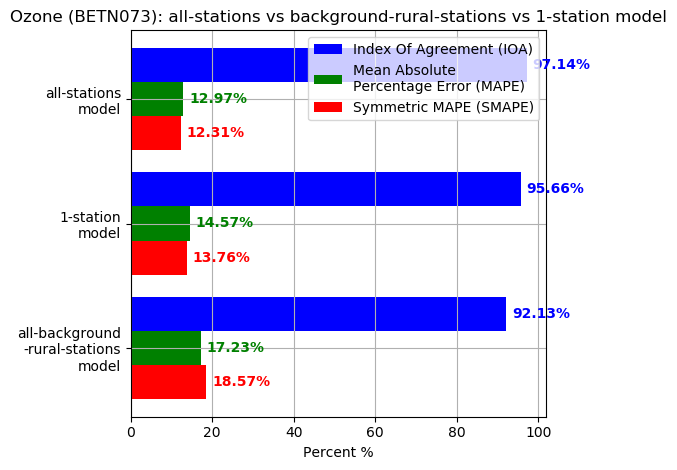

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
# labels = ['all-stations\nmodel', '1-station\nmodel', 'all-background\n-rural-stations\nmodel']
# mape = [12.97, 14.57, 19.79]
# ioa = [97.14, 95.66, 94.53]
# smape = [12.31, 13.76, 16.11]

labels = [ 'all-background\n-rural-stations\nmodel', '1-station\nmodel', 'all-stations\nmodel',]
mape = [17.23, 14.57, 12.97]
ioa = [92.13, 95.66, 97.14]
smape = [18.57, 13.76, 12.31]



x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x + width/2, ioa, width/2, label='Index Of Agreement (IOA)', color='b')
rects2 = ax.barh(x, mape, width/2, label='Mean Absolute\nPercentage Error (MAPE)', color='g')
rects3 = ax.barh(x- width/2, smape, width/2, label='Symmetric MAPE (SMAPE)', color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Percent %')
ax.set_title('Ozone (BETN073): all-stations vs background-rural-stations vs 1-station model')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()
ax.grid(True)


def autolabel(rects, color):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}%'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(25, -5),  # 3 points vertical offset
                    fontweight='bold',
                    color=color,
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, 'b')
autolabel(rects2, 'g')
autolabel(rects3, 'r')

fig.tight_layout()

plt.show()

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
figure_size = (5, 4)
labels = ['Symmetric\nMAPE\n(SMAPE)', 'Mean Absolute\nPercentage\nError\n(MAPE)', 'Index of \nAgreement\n(IoA)']
# mape = [14.57, 12.97]
# ioa = [95.65, 97.14]
# smape = [13.76, 12.31]

model1 = [13.76, 14.57, 95.66]
model46 = [12.31, 12.97, 97.14]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# fig, ax = plt.subplots(figsize=figure_size)
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
rects1 = ax.barh(x + width/2, model46, width, label='46-station model', color='b')
rects2 = ax.barh(x - width/2, model1, width, label='1-station model', color='r')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Percent (%)')
ax.set_title('BETN073 Ozone prediction: 1-station vs 46-station model')
ax.set_title('Ozone (BETN073): all-stations vs 1-station model')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()
ax.grid(True)

def autolabel(rects, color):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}%'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(25, -5),  # 3 points vertical offset
                    fontweight='bold',
                    color=color,
                    textcoords="offset points",
                    ha='center', va='bottom')        
        
autolabel(rects1, 'b')
autolabel(rects2, 'r')

fig.tight_layout()

# plt.show()
fig.savefig("betn073_1vs46.svg")

NameError: name 'pyplot' is not defined

NameError: name 'pyplot' is not defined

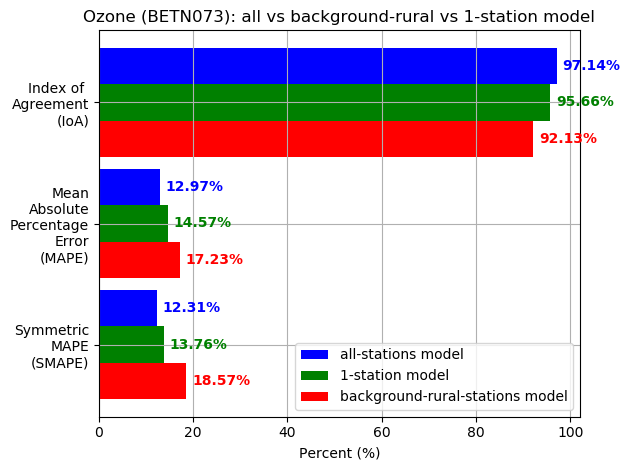

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
labels = ['Symmetric\nMAPE\n(SMAPE)', 'Mean\nAbsolute\nPercentage\nError\n(MAPE)', 'Index of \nAgreement\n(IoA)']
# mape = [14.57, 12.97]
# ioa = [95.65, 97.14]
# smape = [13.76, 12.31]

model1 = [13.76, 14.57, 95.66]
model18 = [18.57, 17.23, 92.13]
model46 = [12.31, 12.97, 97.14]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x + width, model46, width, label='all-stations model', color='b')
rects2 = ax.barh(x, model1, width, label='1-station model', color='g')
rects3 = ax.barh(x - width, model18, width, label='background-rural-stations model', color='r')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Percent (%)')
ax.set_title('Ozone (BETN073): all vs background-rural vs 1-station model')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()
ax.grid(True)

def autolabel(rects, color):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}%'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(25, -5),  # 3 points vertical offset
                    fontweight='bold',
                    color=color,
                    textcoords="offset points",
                    ha='center', va='bottom')        

autolabel(rects1, 'b')  
autolabel(rects2, 'g')     
autolabel(rects3, 'r') 

fig.tight_layout()

# plt.show()
pyplot.savefig("betn073_allVsbackground-ruralVs1-station.svg")

### References:
[1] J. Orellana Alvear. Application of LS-SVMs to ozone forecasting in Belgium, 2015.  
[2] Denis Dumoulin. Fixed-Size Multi-Output LSSVM for Nonlinear System Identification, 2017.  
[3] Christoph Bergmeir, Rob J Hyndman, Bonsoo Koo (2018) A note on the validity of cross-validation for evaluating autoregressive time series prediction. Computational Statistics and Data Analysis, 120, 70-83.  
[4] Neural Architecture Search with Reinforcement Learning, Barret Zoph, Quoc V. Le. International Conference on Learning Representations, 2017.  
[5] Using Evolutionary AutoML to Discover Neural Network Architectures - https://ai.googleblog.com/2018/03/using-evolutionary-automl-to-discover.html  
[6] Ian Goodfellow, Yoshua Bengio, and Aaron Courville. 2016. Deep Learning. The MIT Press.  
[7] Esteban Real, Sherry Moore, Andrew Selle, Saurabh Saxena, Yutaka Leon Suematsu, Jie Tan, Quoc Le: "Large-Scale Evolution of Image Classifiers", 2017  
[8] Lingxue Zhu: "Deep and Confident Prediction for Time Series at Uber", 2017, 2017 IEEE International Conference on Data Mining Workshops. DOI: 10.1109/ICDMW.2017.19  
[9] Makridakis S, Spiliotis E, Assimakopoulos V (2018) Statistical and Machine Learning forecasting methods: Concerns and ways forward. PLOS ONE 13(3): e0194889. https://doi.org/10.1371/journal.pone.0194889  
[10] Esteban Real, Alok Aggarwal, Yanping Huang: "Regularized Evolution for Image Classifier Architecture Search", 2018  
[11] Xin Yao, "Evolving artificial neural networks," in Proceedings of the IEEE, vol. 87, no. 9, pp. 1423-1447, Sept. 1999.
doi: 10.1109/5.784219  
[12] Risto Miikkulainen, Jason Liang, Elliot Meyerson, Aditya Rawal, Dan Fink, Olivier Francon, Bala Raju, Hormoz Shahrzad, Arshak Navruzyan, Nigel Duffy: "Evolving Deep Neural Networks", 2017  
[13] Kenneth O. Stanley and Risto Miikkulainen: "Evolving Neural Networks Through Augmenting Topologies",  Evolutionary Computation  
[14] Variable Length Genomes for Evolutionary Algorithms –C. -y. Lee — 2000 — In Proceedings of the Genetic and Evolutionary Computation Conference, 806. Las Vegas  
[15] Tim Kovacs: Genetics-Based Machine Learning. Handbook of Natural Computing 2012: 937-986  
[16] Kennedy, J.; Eberhart, R. (1995). "Particle Swarm Optimization". Proceedings of IEEE International Conference on Neural Networks. IV. pp. 1942–1948. doi:10.1109/ICNN.1995.488968.  
[17] Storn, R., & Price, K. (1997). Differential Evolution – A Simple and Efficient Heuristic for global Optimization over Continuous Spaces. Journal of Global Optimization, 11(4), 341–359. https://doi.org/10.1023/A:1008202821328  
[18] P. A. Vikhar, "Evolutionary algorithms: A critical review and its future prospects," 2016 International Conference on Global Trends in Signal Processing, Information Computing and Communication (ICGTSPICC), Jalgaon, 2016, pp. 261-265.
doi: 10.1109/ICGTSPICC.2016.7955308  
[19] James Bergstra and Yoshua Bengio. 2012. Random search for hyper-parameter optimization. J. Mach. Learn. Res. 13 (February 2012), 281-305.  
[20] Wales, David J.; Doye, Jonathan P. K. (1997-07-10). "Global Optimization by Basin-Hopping and the Lowest Energy Structures of Lennard-Jones Clusters Containing up to 110 Atoms". The Journal of Physical Chemistry A. 101 (28): 5111–5116. doi:10.1021/jp970984n.  
[21] Stanley, Kenneth O. (2017-07-13). "Neuroevolution: A different kind of deep learning". O'Reilly Media. Retrieved 2017-09-04.  
[22] McCulloch, Warren; Walter Pitts (1943). "A Logical Calculus of Ideas Immanent in Nervous Activity". Bulletin of Mathematical Biophysics. 5 (4): 115–133. doi:10.1007/BF02478259.  
[23] Claesen, Marc, and Bart De Moor. "Hyperparameter Search in Machine Learning." arXiv preprint arXiv:1502.02127 (2015)  
[24] W.N. Martin, J. Lienig, and J.P. Cohoon. Island (migration) models: evolutionary algorithms based on punctuated equilibria. Evolutionary Computation 2: Advanced Algorithms and Operators. Institute of Physics Publishing, Bristol, 2000, chapter 15, pages 101–124.  
[25] Pelikan M. () Probabilistic Model-Building Genetic Algorithms. In: Hierarchical Bayesian Optimization Algorithm. Studies in Fuzziness and Soft Computing, vol 170. Springer, Berlin, Heidelberg  
[26] Pedro Larrañaga; Jose A. Lozano (2002). Estimation of Distribution Algorithms a New Tool for Evolutionary Computation. Boston, MA: Springer US. ISBN 978-1-4615-1539-5.  
[27] Sepp Hochreiter; Jürgen Schmidhuber (1997). "Long short-term memory". Neural Computation. 9 (8): 1735–1780. doi:10.1162/neco.1997.9.8.1735  
[28] Dee DP, Uppala SM, Simmons AJ, Berrisford P, Poli P, Kobayashi S, Andrae U, Balmaseda MA,Balsamo G, Bauer P, Bechtold P, Beljaars ACM, van deBerg L, Bidlot J, Bormann N, Delsol C, Dragani R,Fuentes  M,  Geer  AJ,  Haimberger  L,  Healy  SB,  Hersbach  H,  H ́olm  EV,  Isaksen  L,  K ̊allberg  P,  K ̈ohler  M,Matricardi M, McNally AP, Monge-Sanz BM, Morcrette J-J, Park B-K, Peubey C, de Rosnay P, Tavolato C,Th ́epaut  J-N,  Vitart  F.  2011.  The  ERA-Interim  reanalysis:  configuration  and  performance  of  the  dataassimilation system.Q. J. R. Meteorol. Soc.137: 553 – 597. DOI:10.1002/qj.828  
[29] Armstrong, J. S. (1978). Long-range Forecasting: From Crystal Ball to Computer, Wiley.  
[30] Tofallis, C (2015) "A Better Measure of Relative Prediction Accuracy for Model Selection and Model Estimation", Journal of the Operational Research Society, 66(8),1352-1362.  
[31] Willmott, C. J., S. G. Ackleson, R. E. Davis, J. J. Feddema, K. M. Klink, D. R. Legates, J. O'Donnell, and C. M. Rowe (1985), Statistics for the evaluation and comparison of models, J. Geophys. Res., 90(C5), 8995–9005, doi:10.1029/JC090iC05p08995.  
[32] Makridakis, Spyros, (1993), Accuracy measures: theoretical and practical concerns, International Journal of Forecasting, 9, issue 4, p. 527-529.  
[33] Tomassini, M. (2005). Spatially Structured Evolutionary Algorithms. New York. Springer. https://doi.org/10.1007/3-540-29938-6  
[34] Bergstra, J., Bardenet, R., Bengio, Y., & Kégl, B. (2011). Algorithms for Hyper-Parameter Optimization. In Proceedings of Neural Information Processing Systems (NIPS), 2011. https://doi.org/2012arXiv1206.2944S  
[35] Srivastava, N., Hinton, G., Krizhevsky, A., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research (Vol. 15). Retrieved from http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf  
[36] Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Retrieved from http://arxiv.org/abs/1502.03167  
[37] Klambauer, G., Unterthiner, T., Mayr, A., & Hochreiter, S. (2017). Self-Normalizing Neural Networks. Retrieved from http://arxiv.org/abs/1706.02515  
[38] Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).  
[39] Zeiler, M. D. (2012). ADADELTA: An Adaptive Learning Rate Method.  
[40] Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization.  
[41] Reddi, S. J., Kale, S., & Kumar, S. (2018). On the Convergence of Adam and Beyond. In Proceedings of the International Conference on Learning Representations (ICLR).  
[42] Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013). On the importance of initialization and momentum in deep learning.  